# Taller de Segmentación de Imágenes con autoencoder variacional

Este taller es la continuación del Taller de segmentación de Imágenes. 

En esta ocasión se va a tratar una arquitectura de red neuronal más compleja que el autoencoder estandar. Concretamente se va a realizar de un Autoencoder Variacional (VAE) que presenta algunos detalles de implementación interesantes y varias ventajas sobre el autoencoder corriente. 

En un VAE la huella letente está formada por dos vectores, uno representa la media y otro la varianza de una serie de distribuciones normales. Para que estas distribuciones normales se encuentren normalizadas, se incluye un término de regulación a la función de pérdida que es la divergencia Kullback-Leibler. 

Por otro lado, una vez entrenado el VAE podremos generar nuevos ejemplos con el decodificador modificando los valores de la media y varianza de la huella latente.

![VAE](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/vae.png)

# Dataset

En este notebook utilizamos un pequeño subconjunto del Cityscapes que es un dataset de imágenes recogidas en ciudades alemanas con una cámara situada en el parabrisas de un vehículo. Este dataset contiene las imágenes de segmentación anotadas manualmente y podemos encontrar clases como: coche, moto, camión, persona, carretera, acera, vegetación, edificios, semáforos...

![Cityscapes](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/cityscapes.png)

Para el taller lo hemos reducido a solo 7 clases que son: vehículo, persona, suelo, edificios, vegetación, cielo y fondo (todo lo que no pertenezca a las otras clases)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K

import os
import numpy as np
import matplotlib.pyplot as plt

## Preprocesado de datos
La siguiente celda solo es necesario ejecutarla si estás en google colab, desde binder omitela y omite también el enlace al dataset.

Este es un subconjunto del Cityscapes, añadelo a tu drive https://drive.google.com/file/d/1Y8LOzqYTyyWsEPqiPWdAZp3LSN8fHvSU/view?usp=sharing

En primer lugar tenemos que obtener acceso a nuestro google drive


In [2]:
# from google.colab import drive 
# drive.mount('/content/drive')

Mounted at /content/drive


Buscamos la ruta del datset y lo descomprimimos en la carpeta de destino indicada

In [4]:
!unzip -u "ruta a archivo" -d "ruta a destino"


Archive:  /content/drive/MyDrive/Colab Notebooks/taller segmentacion/taller_segmemtacion_MOVA/minicityscapes.zip


Cargamos los nombres de fichero y los ordenamos

In [7]:
data_path = "ruta a dataset"

x = os.listdir(os.path.join(data_path, "train_images_npy"))
y = os.listdir(os.path.join(data_path, "train_masks_npy"))

# Ordenamos los nombres delos ficheros por sequencia
x.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))
y.sort(key=lambda x: (x.split("f")[-1].split("_")[0], int(x.split("_")[1])))

x = np.array(x)
y = np.array(y)

print('Training size: ', len(x))
print(x[:5])
print(y[:5])

Training size:  51
['f1_0_img.npy' 'f1_1_img.npy' 'f1_2_img.npy' 'f1_3_img.npy'
 'f1_4_img.npy']
['f1_0_msk.npy' 'f1_1_msk.npy' 'f1_2_msk.npy' 'f1_3_msk.npy'
 'f1_4_msk.npy']


Cargamos los datos de entrenamiento en un numpy array.

In [8]:
x_train = [np.load(os.path.join(data_path, "train_images_npy", name)) for name in x]
y_train = [np.load(os.path.join(data_path, "train_masks_npy", name)) for name in y]
print('Training size: ', len(x))

Training size:  51


In [9]:
# Se convierte x_train a un numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

Realizamos una visualización de los datos.

In [10]:
# Esta función reordena la clases de la máscara para visualizar mejor los datos

def reorder_visulization(img_label):
    mask_aux = np.copy(img_label[:, :, 0])
    img_label[:, :, 0] = img_label[:, :, 1]
    img_label[:, :, 1] = img_label[:, :, 3]
    mask_aux2 = np.copy(img_label[:, :, 2])
    img_label[:, :, 2] = img_label[:, :, 4]
    img_label[:, :, 3] = img_label[:, :, 5]
    img_label[:, :, 4] = img_label[:, :, 6]
    img_label[:, :, 5] = mask_aux2
    img_label[:, :, 6] = mask_aux
    return img_label

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)


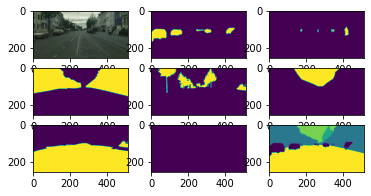

Train images range: : [ 0.03529411764705882 ,  1.0 ]
Test images range: : [ 0.0 , 1.0 ]


In [14]:
n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

img_label = reorder_visulization(img_label)

plt.subplot(4, 3, 1)
plt.imshow(img_in)

# Mostramos cada máscara por separado
plt.subplot(4, 3, 2)
plt.imshow(img_label[:, :, 0])
plt.subplot(4, 3, 3)
plt.imshow(img_label[:, :, 1])
plt.subplot(4, 3, 4)
plt.imshow(img_label[:, :, 2])
plt.subplot(4, 3, 5)
plt.imshow(img_label[:, :, 3])
plt.subplot(4, 3, 6)
plt.imshow(img_label[:, :, 4])
plt.subplot(4, 3, 7)
plt.imshow(img_label[:, :, 5])
plt.subplot(4, 3, 8)
plt.imshow(img_label[:, :, 6])

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.
plt.subplot(4, 3, 9)
plt.imshow(img_all_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label[:, :, 0]), ",", np.amax(img_label[:, :, 0]), "]")

Alguna visualización adicional

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)


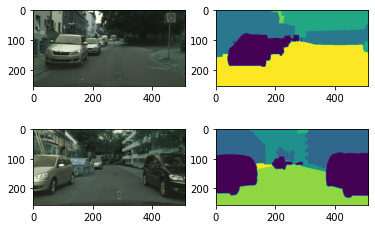

Train images range: : [ 0.054901960784313725 ,  1.0 ]


In [15]:
n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

img_label = reorder_visulization(img_label)

plt.subplot(2, 2, 1)
plt.imshow(img_in)

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.
plt.subplot(2, 2, 2)
plt.imshow(img_all_label)

n_img = np.random.randint(0, x_train.shape[0])
img_in = x_train[n_img]
img_label = y_train[n_img]

img_label = reorder_visulization(img_label)

plt.subplot(2, 2, 3)
plt.imshow(img_in)

# Generamos una imágen con todas las máscaras 
img_all_label = np.argmax(img_label, axis=-1) / 6.
plt.subplot(2, 2, 4)
plt.imshow(img_all_label)

plt.show()

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")

Normalizamos los datos si fuese necesario.

In [16]:
# Normalizamos los datos de entrada en rango [0, 1]
# x_train = x_train / 255. # En este caso ya vienen normalizados por defecto

Las etiquetas de este conjunto de datos ya se encuentran en codificación one hot. En caso de utilizar un dataset que no se encuentre codificado en formato one hot podemos utilizar la siguiente instrucción para transformarlo.

In [17]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)  # to one hot encoding

Revisamos la forma y los valores de los datos. Las etiquetas en codificación one hot tienen que tener forma (h, w, 7)

In [18]:
img_in = x_train[0]
img_label = y_train[0]
print('Input image shape: ', img_in.shape)
print('Label image shape: ', img_label.shape)

print("Train images range: : [", np.amin(img_in), ", ", np.amax(img_in), "]")
print("Test images range: : [", np.amin(img_label), ",", np.amax(img_label), "]")

Input image shape:  (256, 512, 3)
Label image shape:  (256, 512, 7)
Train images range: : [ 0.043137254901960784 ,  1.0 ]
Test images range: : [ 0.0 , 1.0 ]


Separamos un subconjunto de los datos para test. En este caso no se nos da un conjunto de test y es por esto que vamos a extraerlo nosotros de los datos que tenemos.

In [19]:
# saparamos un subconjunto para test
test_split = 0.15
test_split = int(x_train.shape[0] * test_split)
test_idx = np.random.choice(x_train.shape[0], test_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in test_idx else True for i in
                       range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_test = x_train[test_idx]  # Seleccionamos datos de test
y_test = y_train[test_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Test samples: ', x_test.shape[0])

Train samples:  44
Test samples:  7


Separamos un subconjunto de los datos para hacer validación.

In [20]:
# saparamos un subconjunto de validación

val_split = 0.05
val_split = int(x_train.shape[0] * val_split)
val_idx = np.random.choice(x_train.shape[0], val_split, replace=False)  # Seleccionamos varios índices aleatorios
train_mask = np.array([False if i in val_idx else True for i in range(x_train.shape[0])])  # Creamos una máscara para seleccionar los datos de entrenamiento

x_val = x_train[val_idx]  # Seleccionamos datos de validacón
y_val = y_train[val_idx]

x_train = x_train[train_mask]  # Seleccionamos datos de entrenamiento
y_train = y_train[train_mask]

print('Train samples: ', x_train.shape[0])
print('Validation samples: ', x_val.shape[0])

Train samples:  42
Validation samples:  2


# Autoencoder Variacional

Se puede dividir en dos componentes principales: el codificador y el decodificador.



1.   Codificador: Red neuronal que transforma la entrada y la comprime en un vector o huella latente de dimensiones reducidas.
2.   Decodificador: Red neuronal que transforma la huella latente en un vector de características de interes (reconstrucción/descompresión de datos, segmentación, imagen de profundidad)

En el autoencoder variacional la huella latente es una distribución normal multivariada. Esto se corresponde con la obtención de dos vectores, de los cuales uno guarda los valores de la media (μ) de cada distribución normal y el otro la varianza de cada uno (σ). 

A la hora de pasar los valores de la huella latente al decodificador del VAE ,se resliza un muestreo sobre las distribuciones normales que forman la huella latente. Este paso es especialmente delicado ya que muestrear de una distribución normal no es una operación deribable y por lo tanto no nos permitiría entrenar la red. Para solventarlo se utiliza "el truco de la reparametrización" que implementamos más adelante en la función "sampling".

![VAE](https://raw.githubusercontent.com/SergioHdezG/TallerSegmentacionMUVA/master/imagenes/vae.png)


En este ejemplo vamos a construir un modelo de Keras a partir de los submodelos de codificador y decodificador.

In [25]:
 def build_encoder(inputs, input_shape, latent_dim):
    # Construimos el modelo de codificador
    x = inputs

    x = Conv2D(filters=8,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=8,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=8,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(filters=8,
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')(x)

    # Necesitamos la información de las dimensiones de la salida de la última 
    # capa convolucional para poder reconstruir la imagen al tamaño correcto en 
    # el decodificador
    last_conv_shape = K.int_shape(x)

    # Generamos la huella latente
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean', activation=###)(x)
    z_log_var = Dense(latent_dim, name='z_log_var', activation=###)(x)

    # Par usar una función externa en un modelo de Keras tenemos que hacerlo a 
    # través de una capa Lambda. La función sampling realiza el truco de la reparametrización
    # z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    return encoder, last_conv_shape

In [26]:
def build_decoder(latent_dim, shape, out_channels): 
    # Construimos el modelo de decodificador
    latent_input = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_input)
    x = Reshape((shape[1], shape[2], shape[3]))(x)


    x = Conv2DTranspose(filters=8,
                        kernel_size=3,
                        activation='relu',
                        strides=1,
                        padding='same')(x)

    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=8,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=8,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(filters=8,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

    output = Conv2DTranspose(filters=out_channels,
                          kernel_size=3,
                          activation=###,
                          padding='same',
                          name='decoder_output')(x)  # Activación sigmoide para que las salidas estén en rango [0, 1]

                
    # instantiate decoder model
    decoder = tf.keras.models.Model(latent_input, output, name='decoder')
    decoder.summary()
    
    return decoder

In [28]:
 def build_model(input_shape, out_channels, latent_dim):
    # AE model = encoder + decoder
    inputs = Input(shape=input_shape, name='encoder_input')

    encoder, last_conv_shape = build_encoder(inputs, input_shape, latent_dim)
    decoder = build_decoder(latent_dim, last_conv_shape, out_channels) 
    
    # Connectin encoder and decoder VAE model
    z_mean, z_log_var, z_out = encoder(inputs)
    outputs = decoder(z_out)  # Pasamos "z" al decodificador


    # Creamos un tensor que va a gestionar las etiquetas en la forma que necesitemos.
    # Esto es específico para etste ejemplo, normalmente se pasan por la variable 
    # dedicada para allo en la función fit.
    labels = Input(shape=(*input_shape[:-1], out_channels), name='lables')

    vae =  tf.keras.models.Model([inputs, labels], outputs, name='vae')

    # Añadimos la perdida al modelo de froma especial con "add_loss" ya que si 
    # añadimos esta pérdida en el "compile" no va a funcionar correctamente 
    # debido a los datos que requiere como entradas.
    vae_loss = reconstruction_loss(labels, outputs, z_log_var, z_mean, input_shape)
    vae.add_loss(vae_loss)


    vae.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                metrics=tf.keras.metrics.BinaryAccuracy())

    return encoder, decoder, vae


La pérdida en un VAE está compuesta por dos términos

1.   Pérdida de la reconstrucción: Esta mide cuanto se ajusta cada pixel de salida al valor de la etiqueta correspondiente.
2.   Término de regulación KL (Kullback–Leibler): Controla que el espacio latente forme un distribución normal multivariada centrada en cero.



In [29]:
def reconstruction_loss(y_true, y_pred, z_log_var, z_mean, input_shape):

    reconstruction_loss =  tf.keras.losses.###_crossentropy(K.flatten(y_true), K.flatten(y_pred))

    # Le damos más importancia a la pérdida de la reconstrucción en base al tamaño de las imágenes
    reconstruction_loss *= input_shape[0] * input_shape[1]

    # Calculamos el término de regulación Kullback–Leibler
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = - K.mean(kl_loss, axis=-1)

    # Factor de importancia de la regulación
    beta = 0.5
    vae_loss = K.mean(reconstruction_loss + beta * kl_loss)

    return vae_loss

A la hora de muestrear de las distribuciones normales que forman la huella latente es necesario utilizar el "truco de la reparametrización" para que sea posible retropropagar el gradiente. Esto se debe a que muestrear de una distribución normal no es una operación derivable.

Con este fin, se introduce la variable "epsilon" que es un vector de valores que se obtienen muestreando de una distribución normal N(0, 1). El valor de epsilon se utiliza para hacer la selección de z mediante la ecuación: 

z = z_mean + z_log_var * epsilon 

In [30]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Construimos el modelo de VAE.
Seleccionamos el número de canales en función del número de etiquetas.

In [31]:
input_shape = (256, 512, 3)
out_channels= 7
latent_dim = 256

encoder, decoder, vae = build_model(input_shape, out_channels, latent_dim)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 8)  224         ['encoder_input[0][0]']          
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 128, 8)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 64, 8)    584         ['max_pooling2d[0][0]']    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Entrenamos el VAE

Normalmente, en Keras y otras bibliotecas similares, tendríamos que los datos de entrada son x_train y se introduce como etiquetas y_train, tal que:

```
vae.fit(x_train, y_train, epochs...)
```

En este caso hemos definido una función de pérdida especial y se la hemos asignado al modelo de una forma "no estandar". Por esto, hemos creado los dos tensores de entrada "input" para x_train y "labels" para y_train. En esta situación tenemos que introducir los datos de la siguiente forma:

```
vae.fit([x_train, y_train], None, epochs...)
```

Donde `[x_train, y_train]` son las dos entradas a nuestro modelo de Keras. Dado que nuestra función de pérdida no utiliza la variable de entrada por defecto para las etiquetas de la función "fit", en esta se introduce un "None".

Por último, hemos añadido una metrica de la forma convencional. Para que esta métrica funcione debemos introducir las etiquetas de forma convencional. Por lo tanto, introduciremos las etiquetas tanto en el tensor de entrada que hemos preparado para ello como en su variable dedicada de la función "fit", es decir:

```
vae.fit([x_train, y_train], y_train, epochs...)
```

En el caso de los datos de validación hay que introducirlos siguiendo las mismas reglas:

```
validation_data=([x_val, y_val], y_val)
```


In [32]:
batch_size = 64
epochs = 50

vae.fit([x_train, y_train], y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=([x_val, y_val], y_val))

Epoch 1/50
1/1 [==============================] - 33s 33s/step - loss: 90560.3516 - binary_accuracy: 0.6152 - val_loss: 90619.1250 - val_binary_accuracy: 0.6024
Epoch 2/50
1/1 [==============================] - 0s 403ms/step - loss: 90554.7500 - binary_accuracy: 0.6214 - val_loss: 90626.8594 - val_binary_accuracy: 0.5989
Epoch 3/50
1/1 [==============================] - 0s 418ms/step - loss: 90534.7422 - binary_accuracy: 0.6252 - val_loss: 90612.1875 - val_binary_accuracy: 0.6039
Epoch 4/50
1/1 [==============================] - 0s 438ms/step - loss: 90525.0547 - binary_accuracy: 0.6310 - val_loss: 90527.3984 - val_binary_accuracy: 0.6111
Epoch 5/50
1/1 [==============================] - 0s 447ms/step - loss: 90518.6953 - binary_accuracy: 0.6352 - val_loss: 90538.4922 - val_binary_accuracy: 0.6090
Epoch 6/50
1/1 [==============================] - 0s 449ms/step - loss: 90490.0156 - binary_accuracy: 0.6373 - val_loss: 90555.2891 - val_binary_accuracy: 0.6132
Epoch 7/50
1/1 [=============

Salvamos el modelo. En este caso, es necesario guardar el Codificador y Decodificador por separado por dos motivos:


1.   Nos puede interesar utilizar en el futuro usar solo una de las dos partes independientemente.
2.   La unión entre los dos es un poco especial ya que pasan tres tensores de uno a otro y hemos tenido que hacerlo de forma no "estandar". En este caso Keras da problemas al guardar el modelo completo de VAE.

Solo guardamos los pesos debido a que ya tenemos el modelo completo definido en el notebook.



In [ ]:
# encoder_path = 'ruta.../taller_encoder.h5'
# decoder_path = 'ruta.../taller_decoder.h5'

# save_name = encoder_path
# encoder.save_weights(save_name)
# print("Encoder saved  to disk")

# save_name = decoder_path
# decoder.save_weights(save_name)
# print("Decoder saved  to disk")

Para cargar el VAE, tendremos que cargar ambos submodelos (codificador y decodificador). En caso de que no hayamos construido anteriormente el VAE tendremos que hacerlo antes de cargar os pesos con la función "build_model"

In [ ]:
# encoder_path = 'ruta.../taller_encoder.h5'
# decoder_path = 'ruta.../taller_decoder.h5'

# # Si no se hubiese creado el modelo todavía habria que crear uno nuevo con la siguiente linea
# # encoder, decoder, vae = build_model(input_shape, out_channels, latent_dim)

# # load weights into new model
# encoder.load_weights(encoder_path)

# # load weights into new model
# decoder.load_weights(decoder_path)

# # Si fuesemos a reentrenar necesitariamos compilamos el modelo de nuevo
# # vae.compile(optimizer='adam')

# Testing


La función evaluate realiza un predict sobre cada entrada del conjunto de test y extrae las métricas que hayamos indicado al compilar el modelo.

In [33]:
vae.evaluate([x_test, y_test], y_test, batch_size=batch_size)

1/1 [==============================] - 0s 353ms/step - loss: 88543.6641 - binary_accuracy: 0.7259


[88543.6640625, 0.7259407043457031]

Por último, vamos a visualizar algunos de los resultados. 

La siguiente celda selecciona varias imágenes aleatorias y muestra su salida.

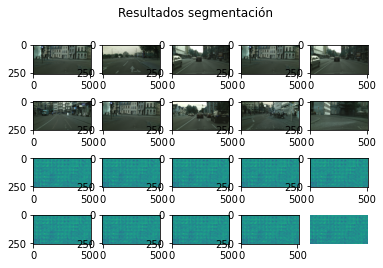

In [34]:
figsize = 5
num_examples_to_generate = figsize*figsize
fig = plt.figure()
fig.suptitle('Resultados segmentación')
examples_index = np.random.choice(x_test.shape[0], figsize*2)
examples = x_test[examples_index]
z_mean, z_log_var, z = encoder.predict(examples)
predictions = decoder.predict(z_mean)


predictions = np.argmax(predictions, axis=-1) / 6.

for i in range(figsize*2):

    plt.subplot(4, figsize, i+1)
    plt.imshow(examples[i])
    plt.subplot(4, figsize, i + 1 + figsize*2)
    plt.imshow(predictions[i])

plt.axis('off')
plt.show()

Una característica interesande de los VAE es que su decodificador es un modelo generador. Podemos crear una huella latente y ajustar sus parámetros para obtener imágenes nuevas.

Por ejemplo con una red que segmente el tráfico, podríamos crear imagenes de segmentación de nuevas situaciones y a su vez utilizarlas para entrenar otro algoritmo en el manejo de un vehículo autónomo.

En la celda siguiente se muestrean varias huellas latentes sobre una distribución normal para crear nuevos ejemplos.



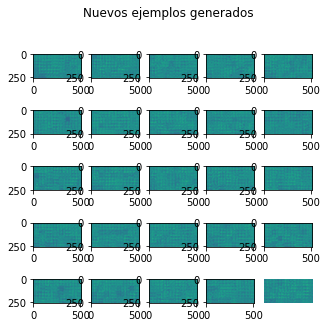

In [35]:
random_vector_for_generation = np.random.normal(size=(num_examples_to_generate, latent_dim))

predictions = decoder.predict(random_vector_for_generation)

predictions = np.argmax(predictions, axis=-1) / 6.
fig = plt.figure(figsize=(figsize, figsize))
fig.suptitle('Nuevos ejemplos generados')
for i in range(num_examples_to_generate):
    plt.subplot(figsize, figsize, i+1)
    plt.imshow(predictions[i])
plt.axis('off')
plt.show()